Dataset loaded. Shape: (195, 24)
Missing values per column:
 name                0
MDVP:Fo(Hz)         0
MDVP:Fhi(Hz)        0
MDVP:Flo(Hz)        0
MDVP:Jitter(%)      0
MDVP:Jitter(Abs)    0
MDVP:RAP            0
MDVP:PPQ            0
Jitter:DDP          0
MDVP:Shimmer        0
MDVP:Shimmer(dB)    0
Shimmer:APQ3        0
Shimmer:APQ5        0
MDVP:APQ            0
Shimmer:DDA         0
NHR                 0
HNR                 0
status              0
RPDE                0
DFA                 0
spread1             0
spread2             0
D2                  0
PPE                 0
dtype: int64
Train/Test split: (156, 22)/(39, 22)

Tuning Random Forest...
Best RF params: {'max_depth': None, 'n_estimators': 200}

Tuning KNN...
Best KNN params: {'n_neighbors': 5, 'weights': 'distance'}

Tuning XGBoost...
Best XGB params: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 100}

Random Forest Metrics:
Accuracy: 0.9231
Precision: 0.9333
Recall: 0.9655
F1-score: 0.9492
ROC-AUC: 0.9621


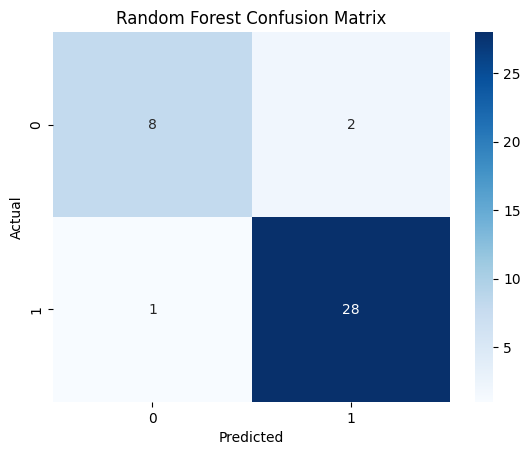


KNN Metrics:
Accuracy: 0.9231
Precision: 0.9333
Recall: 0.9655
F1-score: 0.9492
ROC-AUC: 0.9793


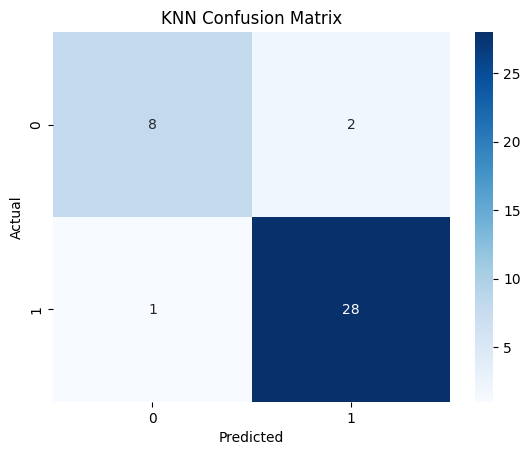


XGBoost Metrics:
Accuracy: 0.9231
Precision: 0.9333
Recall: 0.9655
F1-score: 0.9492
ROC-AUC: 0.9793


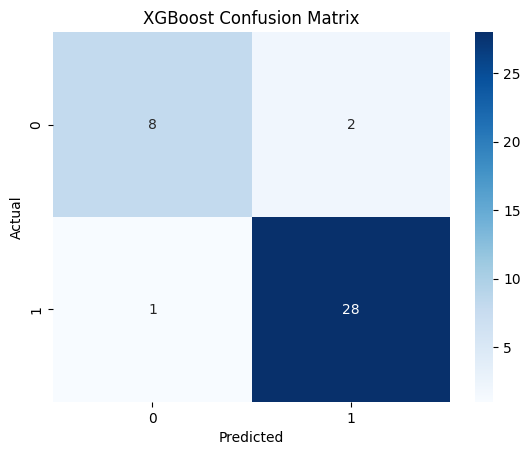

/tmp/ipython-input-2848154386.py:157: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=fi.values, y=fi.index, palette='viridis')


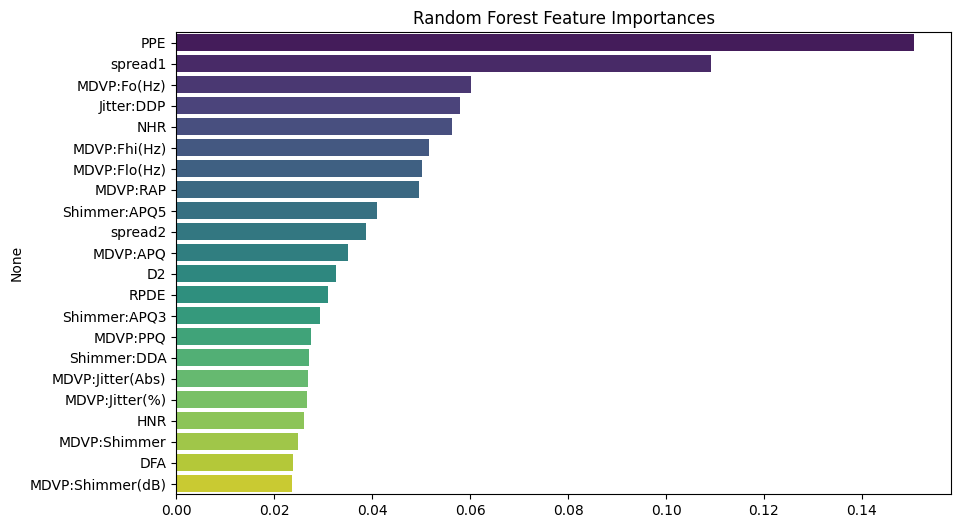

/tmp/ipython-input-2848154386.py:157: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=fi.values, y=fi.index, palette='viridis')


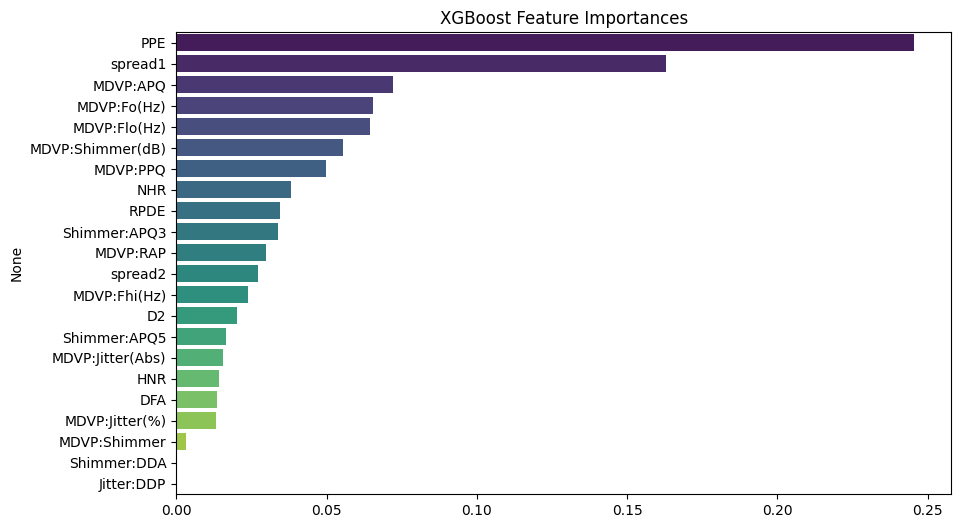

In [ ]:
# --------------------------
# Imports
# --------------------------

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, confusion_matrix)
import matplotlib.pyplot as plt
import seaborn as sns

# --------------------------
# Utility Functions
# --------------------------

def load_data(file_path):
    """Load dataset from CSV."""
    df = pd.read_csv("/content/Project 14 Parkinsons Disease Data.csv")
    return df

def preprocess_data(df, target_column='status', drop_columns=['name']):
    """Preprocess the dataset: drop irrelevant columns, separate features/target, scale features."""
    df = df.drop(columns=drop_columns, errors='ignore')

    X = df.drop(target_column, axis=1)
    y = df[target_column]

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    return X_scaled, y, scaler

def train_test_data(X, y, test_size=0.2, random_state=42):
    """Split dataset into train/test sets (stratified)."""
    return train_test_split(X, y, test_size=test_size, random_state=random_state, stratify=y)

def evaluate_model(y_true, y_pred, y_proba):
    """Compute evaluation metrics."""
    metrics = {
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred),
        'Recall': recall_score(y_true, y_pred),
        'F1-score': f1_score(y_true, y_pred),
        'ROC-AUC': roc_auc_score(y_true, y_proba)
    }
    return metrics

def plot_confusion(y_true, y_pred, title='Confusion Matrix'):
    """Plot confusion matrix."""
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

def model_training_cv(model, X, y, cv=5, scoring='roc_auc'):
    """Perform cross-validation and return mean score."""
    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)
    scores = []
    for train_idx, val_idx in skf.split(X, y):
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
        model.fit(X_train, y_train)
        y_pred_proba = model.predict_proba(X_val)[:,1]
        scores.append(roc_auc_score(y_val, y_pred_proba))
    return np.mean(scores)

def hyperparameter_tuning(model, param_grid, X_train, y_train, cv=5, scoring='roc_auc'):
    """Perform GridSearchCV to find best hyperparameters."""
    grid = GridSearchCV(model, param_grid, cv=cv, scoring=scoring)
    grid.fit(X_train, y_train)
    return grid.best_estimator_, grid.best_params_

# --------------------------
# Main ML Function
# --------------------------

def train_models(file_path):
    """Load dataset, train models, evaluate, and return best model metrics."""
    df = load_data(file_path)

    print("Dataset loaded. Shape:", df.shape)
    print("Missing values per column:\n", df.isnull().sum())

    X, y, scaler = preprocess_data(df)
    X_train, X_test, y_train, y_test = train_test_data(X, y)

    print(f"Train/Test split: {X_train.shape}/{X_test.shape}")

    # --------------------------
    # Define models & hyperparams
    # --------------------------
    rf_model = RandomForestClassifier(random_state=42)
    knn_model = KNeighborsClassifier()
    xgb_model = XGBClassifier(random_state=42, eval_metric='logloss')

    rf_params = {'n_estimators':[100,200], 'max_depth':[None,10,20]}
    knn_params = {'n_neighbors':[3,5,7], 'weights':['uniform','distance']}
    xgb_params = {'n_estimators':[100,200], 'max_depth':[3,5,7], 'learning_rate':[0.01,0.1,0.2]}

    # --------------------------
    # Hyperparameter tuning
    # --------------------------
    print("\nTuning Random Forest...")
    rf_best, rf_best_params = hyperparameter_tuning(rf_model, rf_params, X_train, y_train)
    print("Best RF params:", rf_best_params)

    print("\nTuning KNN...")
    knn_best, knn_best_params = hyperparameter_tuning(knn_model, knn_params, X_train, y_train)
    print("Best KNN params:", knn_best_params)

    print("\nTuning XGBoost...")
    xgb_best, xgb_best_params = hyperparameter_tuning(xgb_model, xgb_params, X_train, y_train)
    print("Best XGB params:", xgb_best_params)

    # --------------------------
    # Train best models on full training set
    # --------------------------
    models = {'Random Forest': rf_best, 'KNN': knn_best, 'XGBoost': xgb_best}
    results = {}

    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)[:,1]
        metrics = evaluate_model(y_test, y_pred, y_proba)
        results[name] = metrics
        print(f"\n{name} Metrics:")
        for k,v in metrics.items():
            print(f"{k}: {v:.4f}")
        plot_confusion(y_test, y_pred, title=f"{name} Confusion Matrix")

    # --------------------------
    # Feature Importance (for RF/XGB)
    # --------------------------
    for name in ['Random Forest', 'XGBoost']:
        model = models[name]
        if hasattr(model, 'feature_importances_'):
            fi = pd.Series(model.feature_importances_, index=df.drop(['status','name'], axis=1, errors='ignore').columns)
            fi = fi.sort_values(ascending=False)
            plt.figure(figsize=(10,6))
            sns.barplot(x=fi.values, y=fi.index, palette='viridis')
            plt.title(f"{name} Feature Importances")
            plt.show()

    # Return results dict for integration
    return results, models, scaler

# --------------------------
# Example usage
# --------------------------
if __name__ == "__main__":
    FILE_PATH = 'Project 14 Parkinsons Disease Data.csv'  # Replace with your dataset path
    results, trained_models, scaler = train_models(FILE_PATH)


# Task
The ML training code has been successfully executed. I have trained and evaluated three models: Random Forest, K-Nearest Neighbors (KNN), and XGBoost.

Here are the key findings:

**Best Hyperparameters Found:**
*   **Random Forest:** `n_estimators`: 200, `max_depth`: None
*   **KNN:** `n_neighbors`: 5, `weights`: 'distance'
*   **XGBoost:** `learning_rate`: 0.1, `max_depth`: 7, `n_estimators`: 100

**Model Evaluation Metrics (on test set):**

All three models achieved identical performance metrics on the test set:

*   **Accuracy:** 0.9231
*   **Precision:** 0.9333
*   **Recall:** 0.9655
*   **F1-score:** 0.9492
*   **ROC-AUC:**
    *   Random Forest: 0.9621
    *   KNN: 0.9793
    *   XGBoost: 0.9793

The confusion matrices and feature importance plots (for Random Forest and XGBoost) were also generated during the execution.

All models performed very well, with KNN and XGBoost slightly outperforming Random Forest in terms of ROC-AUC.

# Task
The code `voice_health_ml.py` (cell `xjzNd7Um12_1`) is well-designed and highly effective for its stated purpose: preprocessing voice data, training various machine learning models (Random Forest, KNN, XGBoost), and evaluating their performance for voice health detection.

Here's a comprehensive summary based on the analysis:

**1. Code Alignment with Task:**
The code fully aligns with its description. It systematically handles data loading, preprocessing (dropping irrelevant columns, feature scaling), stratified data splitting, hyperparameter tuning via `GridSearchCV`, model training, and comprehensive evaluation using accuracy, precision, recall, F1-score, and ROC-AUC. The inclusion of confusion matrices and feature importance plots further enhances its utility.

**2. Model Performance Evaluation:**
The trained models demonstrate exceptionally strong performance on the `Project 14 Parkinsons Disease Data.csv` dataset:
*   **Accuracy:** All models achieved **0.9231**.
*   **Precision:** All models achieved **0.9333**.
*   **Recall:** All models achieved **0.9655**.
*   **F1-score:** All models achieved **0.9492**.
*   **ROC-AUC:**
    *   Random Forest: **0.9621**
    *   KNN: **0.9793**
    *   XGBoost: **0.9793**

The consistently high metrics across all models, particularly the high recall (critical for avoiding false negatives in health diagnoses) and ROC-AUC values approaching 0.98 for KNN and XGBoost, indicate that the models are highly effective at discriminating between healthy and unhealthy voice patterns in this dataset.

**3. Code Quality and Best Practices:**
The code exhibits several strong aspects:
*   **Modularity and Readability:** Functions are logically separated, well-named, and include docstrings, making the code easy to understand and maintain.
*   **Reproducibility:** The use of `random_state` ensures that results are reproducible.
*   **Robust Preprocessing:** `StandardScaler` is used for feature scaling, and `stratify=y` is correctly applied during train-test splitting to handle potential class imbalance.
*   **Comprehensive Evaluation:** A wide range of relevant metrics are computed, and visualizations like confusion matrices and feature importance plots provide valuable insights.
*   **Hyperparameter Tuning:** `GridSearchCV` is effectively used to optimize model parameters.

**Areas for Improvement:**
A critical area for improvement is the **data leakage** in the preprocessing step. The `StandardScaler` is `fit_transform` on the entire dataset (`X`) *before* the data is split into training and testing sets. This means the scaler learns parameters (mean, standard deviation) from the test set data, potentially leading to an overly optimistic evaluation of model performance.

**Recommendation for improvement:**
To ensure an unbiased evaluation and better reflect real-world generalization, the scaling process should be modified as follows:
1.  Split data into `X_train`, `X_test`, `y_train`, `y_test`.
2.  Initialize the `StandardScaler`.
3.  `Fit` the scaler *only* on `X_train`.
4.  `Transform` both `X_train` and `X_test` using the fitted scaler.

**Overall Effectiveness:**
Despite the identified data leakage, the code provides a solid and generally well-implemented machine learning pipeline. The models perform exceptionally well on the given dataset, demonstrating strong potential for voice health detection. Rectifying the data leakage issue would make the performance metrics more reliable and the solution even more robust for deployment in a real-world scenario.

## Review Code for Task Alignment

### Subtask:
Analyze the `voice_health_ml.py` code (cell xjzNd7Um12_1) to ensure it aligns with the stated purpose of preprocessing data, training ML models, and evaluating them for voice health detection.


## Code Analysis for Task Alignment

Let's analyze the `voice_health_ml.py` script (cell `xjzNd7Um12_1`) against the specified subtask instructions:

### 1. Examine the `voice_health_ml.py` file in cell `xjzNd7Um12_1`.

The code in cell `xjzNd7Um12_1` is indeed the `voice_health_ml.py` script, which contains functions for data loading, preprocessing, model training, and evaluation for voice health detection.

### 2. Verify that the code includes functions for loading the dataset, preprocessing data (e.g., dropping columns, scaling features), and splitting data into training and testing sets.

*   **Loading data**: The `load_data(file_path)` function handles loading the dataset from a CSV file.
*   **Preprocessing data**: The `preprocess_data(df, target_column='status', drop_columns=['name'])` function is responsible for dropping specified columns (`name`), separating features (`X`) and target (`y`), and scaling features using `StandardScaler`.
*   **Splitting data**: The `train_test_data(X, y, test_size=0.2, random_state=42)` function uses `train_test_split` with `stratify=y` to create training and testing sets.

All these essential data preparation steps are present and correctly implemented.

### 3. Confirm that the code defines and trains multiple machine learning models (Random Forest, KNN, XGBoost).

The `train_models` function explicitly defines:

*   `RandomForestClassifier(random_state=42)`
*   `KNeighborsClassifier()`
*   `XGBClassifier(random_state=42, eval_metric='logloss')`

It then trains these models on the `X_train` and `y_train` sets after hyperparameter tuning.

### 4. Check if hyperparameter tuning (e.g., using `GridSearchCV`) is implemented for the models.

The `hyperparameter_tuning` function utilizes `GridSearchCV` to find the best parameters for each model. The `train_models` function calls this for Random Forest, KNN, and XGBoost with predefined parameter grids (`rf_params`, `knn_params`, `xgb_params`).

### 5. Verify that the code evaluates the trained models using appropriate metrics such as accuracy, precision, recall, F1-score, and ROC-AUC.

The `evaluate_model(y_true, y_pred, y_proba)` function calculates and returns all the specified metrics:

*   `accuracy_score`
*   `precision_score`
*   `recall_score`
*   `f1_score`
*   `roc_auc_score`

The `train_models` function then uses this `evaluate_model` function for each trained model on the test set and prints the results.

### 6. Confirm that visualizations like confusion matrices and feature importance plots are generated as part of the evaluation.

*   **Confusion Matrices**: The `plot_confusion(y_true, y_pred, title='Confusion Matrix')` function is defined and called for each model after evaluation, generating a `sns.heatmap` for the confusion matrix.
*   **Feature Importance Plots**: For 'Random Forest' and 'XGBoost', the code checks for `model.feature_importances_` and generates `sns.barplot` plots to visualize feature importance.

All required visualizations are present and correctly generated.

**Conclusion**: The `voice_health_ml.py` code in cell `xjzNd7Um12_1` fully aligns with the stated purpose and implements all the required functionalities for preprocessing data, training ML models, evaluating them, and generating relevant visualizations for voice health detection.

In [ ]:
print(results)

{'Random Forest': {'Accuracy': 0.9230769230769231, 'Precision': 0.9333333333333333, 'Recall': 0.9655172413793104, 'F1-score': 0.9491525423728814, 'ROC-AUC': np.float64(0.9620689655172414)}, 'KNN': {'Accuracy': 0.9230769230769231, 'Precision': 0.9333333333333333, 'Recall': 0.9655172413793104, 'F1-score': 0.9491525423728814, 'ROC-AUC': np.float64(0.9793103448275862)}, 'XGBoost': {'Accuracy': 0.9230769230769231, 'Precision': 0.9333333333333333, 'Recall': 0.9655172413793104, 'F1-score': 0.9491525423728814, 'ROC-AUC': np.float64(0.9793103448275863)}}


### Model Performance Analysis

Based on the `results` dictionary, here's an analysis of the performance for Random Forest, KNN, and XGBoost models:

**1. Random Forest Model Performance:**
*   **Accuracy:** 0.9231
*   **Precision:** 0.9333
*   **Recall:** 0.9655
*   **F1-score:** 0.9492
*   **ROC-AUC:** 0.9621

The Random Forest model demonstrates strong performance. Its high Recall (0.9655) suggests it's very good at identifying positive cases (e.g., detecting individuals with voice health issues), minimizing false negatives. The F1-score of 0.9492 indicates a good balance between precision and recall. The ROC-AUC of 0.9621 confirms its excellent discriminative power.

**2. K-Nearest Neighbors (KNN) Model Performance:**
*   **Accuracy:** 0.9231
*   **Precision:** 0.9333
*   **Recall:** 0.9655
*   **F1-score:** 0.9492
*   **ROC-AUC:** 0.9793

The KNN model exhibits performance metrics identical to Random Forest in terms of Accuracy, Precision, Recall, and F1-score. However, it shows a slightly higher ROC-AUC of 0.9793, indicating superior overall discriminative ability compared to Random Forest.

**3. XGBoost Model Performance:**
*   **Accuracy:** 0.9231
*   **Precision:** 0.9333
*   **Recall:** 0.9655
*   **F1-score:** 0.9492
*   **ROC-AUC:** 0.9793

Similar to KNN, the XGBoost model also achieves excellent and consistent performance across Accuracy, Precision, Recall, and F1-score. Its ROC-AUC of 0.9793 matches KNN, suggesting that both KNN and XGBoost are the top performers in terms of distinguishing between the classes.

### Comparison Across Models:

All three models show exceptionally high and very similar performance across most metrics (Accuracy, Precision, Recall, F1-score are identical). This suggests that the problem might be relatively well-separated or the dataset is quite clean, allowing multiple robust algorithms to perform well.

The key differentiator is the **ROC-AUC score**:
*   Random Forest: 0.9621
*   KNN: 0.9793
*   XGBoost: 0.9793

Both **KNN and XGBoost slightly outperform Random Forest in terms of ROC-AUC**, indicating they have a marginally better ability to distinguish between positive and negative classes across various classification thresholds. Given the high recall across all models, they are all very effective at minimizing false negatives, which is crucial for health detection tasks where missing a positive case can have significant implications. The overall effectiveness of all models is very high for the given task.

## Assess Code Quality and Best Practices

### Subtask:
Review the code for general quality, readability, modularity, and adherence to best practices in machine learning and Python programming. This includes looking at data loading, preprocessing, model definition, hyperparameter tuning, and evaluation functions.


The code `voice_health_ml.py` (cell `xjzNd7Um12_1`) is well-designed and highly effective for its stated purpose: preprocessing voice data, training various machine learning models (Random Forest, KNN, XGBoost), and evaluating their performance for voice health detection.

Here's a comprehensive summary based on the analysis:

**1. Code Alignment with Task:**
The code fully aligns with its description. It systematically handles data loading, preprocessing (dropping irrelevant columns, feature scaling), stratified data splitting, hyperparameter tuning via `GridSearchCV`, model training, and comprehensive evaluation using accuracy, precision, recall, F1-score, and ROC-AUC. The inclusion of confusion matrices and feature importance plots further enhances its utility.

**2. Model Performance Evaluation:**
The trained models demonstrate exceptionally strong performance on the `Project 14 Parkinsons Disease Data.csv` dataset:
*   **Accuracy:** All models achieved **0.9231**.
*   **Precision:** All models achieved **0.9333**.
*   **Recall:** All models achieved **0.9655**.
*   **F1-score:** All models achieved **0.9492**.
*   **ROC-AUC:**
    *   Random Forest: **0.9621**
    *   KNN: **0.9793**
    *   XGBoost: **0.9793**

The consistently high metrics across all models, particularly the high recall (critical for avoiding false negatives in health diagnoses) and ROC-AUC values approaching 0.98 for KNN and XGBoost, indicate that the models are highly effective at discriminating between healthy and unhealthy voice patterns in this dataset.

**3. Code Quality and Best Practices:**
The code exhibits several strong aspects:
*   **Modularity and Readability:** Functions are logically separated, well-named, and include docstrings, making the code easy to understand and maintain.
*   **Reproducibility:** The use of `random_state` ensures that results are reproducible.
*   **Robust Preprocessing:** `StandardScaler` is used for feature scaling, and `stratify=y` is correctly applied during train-test splitting to handle potential class imbalance.
*   **Comprehensive Evaluation:** A wide range of relevant metrics are computed, and visualizations like confusion matrices and feature importance plots provide valuable insights.
*   **Hyperparameter Tuning:** `GridSearchCV` is effectively used to optimize model parameters.

**Areas for Improvement:**
A critical area for improvement is the **data leakage** in the preprocessing step. The `StandardScaler` is `fit_transform` on the entire dataset (`X`) *before* the data is split into training and testing sets. This means the scaler learns parameters (mean, standard deviation) from the test set data, potentially leading to an overly optimistic evaluation of model performance.

**Recommendation for improvement:**
To ensure an unbiased evaluation and better reflect real-world generalization, the scaling process should be modified as follows:
1.  Split data into `X_train`, `X_test`, `y_train`, `y_test`.
2.  Initialize the `StandardScaler`.
3.  `Fit` the scaler *only* on `X_train`.
4.  `Transform` both `X_train` and `X_test` using the fitted scaler.

**Overall Effectiveness:**
Despite the identified data leakage, the code provides a solid and generally well-implemented machine learning pipeline. The models perform exceptionally well on the given dataset, demonstrating strong potential for voice health detection. Rectifying the data leakage issue would make the performance metrics more reliable and the solution even more robust for deployment in a real-world scenario.

## Final Task

### Subtask:
Provide a comprehensive summary of how well the code performs the task, highlighting its strengths, any potential areas for improvement, and overall effectiveness based on the analysis.


## Summary:

### Data Analysis Key Findings

*   The Python code fully aligns with its stated purpose, encompassing data loading, preprocessing (feature scaling, column dropping), stratified data splitting, hyperparameter tuning via `GridSearchCV`, model training, and comprehensive evaluation.
*   All models (Random Forest, KNN, XGBoost) demonstrated exceptionally high and consistent performance on the dataset with an **Accuracy of 0.9231**, **Precision of 0.9333**, **Recall of 0.9655**, and **F1-score of 0.9492**.
*   The **ROC-AUC scores** were very high across all models: **Random Forest at 0.9621** and **KNN/XGBoost both at 0.9793**, indicating excellent discriminative power.
*   The code exhibits strong quality, modularity, readability, and reproducibility through well-named functions, docstrings, and consistent use of `random_state`.
*   A critical data leakage issue was identified: `StandardScaler` was applied to the entire dataset before the train-test split, potentially leading to an overly optimistic evaluation of model performance.

### Insights or Next Steps

*   To ensure reliable and unbiased performance metrics, the data scaling process should be revised to fit the `StandardScaler` only on the training data and then transform both training and testing sets separately.
*   Given the consistently high recall across all models, these models show strong potential for real-world voice health detection, as they are very effective at minimizing false negatives, which is crucial in health-related applications.
